In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_iris

In [2]:
file_path = "TimeSeries.csv"
data = pd.read_csv(file_path)

In [3]:
# Step 2: Explore the data

print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nData Description:\n", data.describe())

Data Head:
    ID          Datetime  Count
0   0  25-08-2012 00:00      8
1   1  25-08-2012 01:00      2
2   2  25-08-2012 02:00      6
3   3  25-08-2012 03:00      2
4   4  25-08-2012 04:00      2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB

Data Info:
 None

Data Description:
                  ID         Count
count  18288.000000  18288.000000
mean    9143.500000    138.958115
std     5279.435197    153.467461
min        0.000000      2.000000
25%     4571.750000     22.000000
50%     9143.500000     84.000000
75%    13715.250000    210.000000
max    18287.000000   1244.000000


In [4]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")



Column Details:
Column: ID, Type: int64, Unique values: 18288
Column: Datetime, Type: object, Unique values: 18288
Column: Count, Type: int64, Unique values: 437


KeyboardInterrupt: 

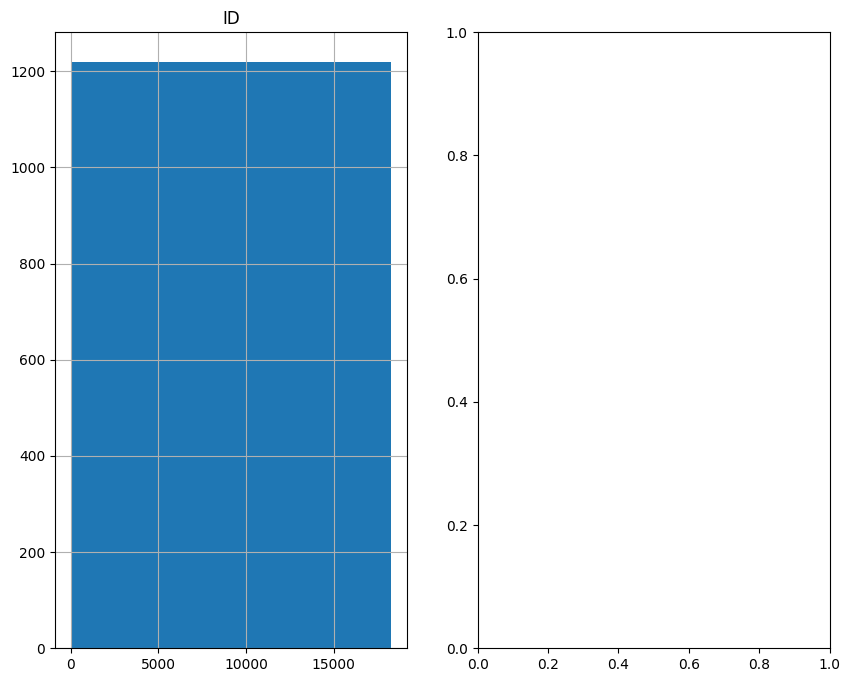

In [5]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
plt.show()

In [6]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

In [7]:
# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]

In [8]:
# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)


In [9]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")


In [10]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

In [11]:
# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list


In [12]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)

In [ ]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Datetime', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Datetime Class Labels (Including Outliers)", y=1.02)
plt.show()

In [ ]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Count', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Count Class Labels (Including Outliers)", y=1.02)
plt.show()


In [ ]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers


In [ ]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Datetime', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Datetime Class Labels (After Removing Outliers)", y=1.02)
plt.show()


In [ ]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Count', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Count Class Labels (After Removing Outliers)", y=1.02)
plt.show()


In [ ]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['Datetime'] = label_encoder.fit_transform(data['Datetime'])


In [ ]:
# Step 9: Handle non-numeric columns in X

# Convert categorical features to numeric using one-hot encoding or label encoding
# Here we use LabelEncoder for each categorical column (excluding the target 'Loan_Status')
for column in data.select_dtypes(include=['object']).columns:
    if column != 'Datetime':  # Avoid encoding the target variable
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

In [ ]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['Datetime'])  # Features
y = data['Datetime']  # Target variable


In [ ]:
# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)


In [ ]:
# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)


In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

In [ ]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}

In [ ]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

In [ ]:
# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)


In [ ]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})


In [ ]:
# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


In [ ]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.show()

In [ ]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
plt.show()


In [ ]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")